In [1]:
MAKE_BOOK_FIGURES=Trueimport numpy as npimport scipy.stats as stimport matplotlib as mplimport matplotlib.pyplot as plt%matplotlib inlineimport matplotlib_inlinematplotlib_inline.backend_inline.set_matplotlib_formats('svg')import seaborn as snssns.set_context("paper")sns.set_style("ticks")def set_book_style():    plt.style.use('seaborn-v0_8-white')     sns.set_style("ticks")    sns.set_palette("deep")    mpl.rcParams.update({        # Font settings        'font.family': 'serif',  # For academic publishing        'font.size': 8,  # As requested, 10pt font        'axes.labelsize': 8,        'axes.titlesize': 8,        'xtick.labelsize': 7,  # Slightly smaller for better readability        'ytick.labelsize': 7,        'legend.fontsize': 7,                # Line and marker settings for consistency        'axes.linewidth': 0.5,        'grid.linewidth': 0.5,        'lines.linewidth': 1.0,        'lines.markersize': 4,                # Layout to prevent clipped labels        'figure.constrained_layout.use': True,                # Default DPI (will override when saving)        'figure.dpi': 600,        'savefig.dpi': 600,                # Despine - remove top and right spines        'axes.spines.top': False,        'axes.spines.right': False,                # Remove legend frame        'legend.frameon': False,                # Additional trim settings        'figure.autolayout': True,  # Alternative to constrained_layout        'savefig.bbox': 'tight',    # Trim when saving        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off    })def set_notebook_style():    plt.style.use('seaborn-v0_8-white')    sns.set_style("ticks")    sns.set_palette("deep")    mpl.rcParams.update({        # Font settings - using default sizes        'font.family': 'serif',        'axes.labelsize': 10,        'axes.titlesize': 10,        'xtick.labelsize': 9,        'ytick.labelsize': 9,        'legend.fontsize': 9,                # Line and marker settings        'axes.linewidth': 0.5,        'grid.linewidth': 0.5,        'lines.linewidth': 1.0,        'lines.markersize': 4,                # Layout settings        'figure.constrained_layout.use': True,                # Remove only top and right spines        'axes.spines.top': False,        'axes.spines.right': False,                # Remove legend frame        'legend.frameon': False,                # Additional settings        'figure.autolayout': True,        'savefig.bbox': 'tight',        'savefig.pad_inches': 0.1    })def save_for_book(fig, filename, is_vector=True, **kwargs):    """    Save a figure with book-optimized settings.        Parameters:    -----------    fig : matplotlib figure        The figure to save    filename : str        Filename without extension    is_vector : bool        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.    **kwargs : dict        Additional kwargs to pass to savefig    """        # Set appropriate DPI and format based on figure type    if is_vector:        dpi = 1000        ext = '.pdf'    else:        dpi = 600        ext = '.tif'        # Save the figure with book settings    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)def make_full_width_fig():    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)def make_half_width_fig():    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)if MAKE_BOOK_FIGURES:    set_book_style()else:    set_notebook_style()make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

# Gaussian Process Regression Without Noise

We perform Gaussian process regression on a synthetic 1D dataset without noise.

## Example: Gaussian process regression in 1D with fixed hyper-parameters

Let's generate some synthetic 1D data to work with:

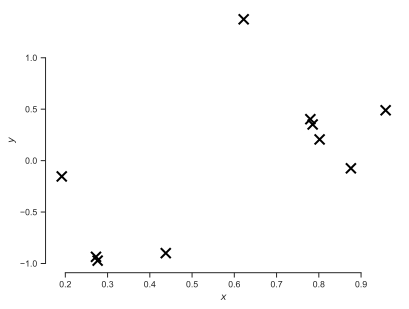

In [27]:
np.random.seed(1234)

# Number of observations
n = 10
# The inputs are in [0, 1]
X = np.random.rand(n) 
# The true function that we will try to identify
f_true = lambda x: -np.cos(np.pi * x) + np.sin(4. * np.pi * x)
# Some data to train on
Y = f_true(X)
# Let's visualize the data
fig, ax = plt.subplots()
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
sns.despine(trim=True);

Don't forget to install GPyTorch first if you are running this notebook on Colab:

In [ ]:
!pip install gpytorch

A GPyTorch GP model requires a mean function, a covariance function (kernel), and a likelihood function.
For simplicity, we will use a constant mean function, so we will set:
$$
m(x) = 0.
$$
Our kernel is the squared exponential kernel. 
We will use a Gaussian likelihood function.

In [47]:
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel

class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(0.0)
)
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y, likelihood)

Here is how the model looks like if you try to print it:

In [48]:
print(model)

ExactGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(0.000E+00)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)


You see all the parameters. We are going to pick the parameters by hand in this example.

In [50]:
model.mean_module.constant = torch.tensor(0.0)
model.covar_module.outputscale = torch.tensor(1.0)
model.covar_module.base_kernel.lengthscale = torch.tensor(0.1)
model.likelihood.noise = torch.tensor(0.0) # There is no noise in the data

That's it. We have now specified the model completely.
The posterior GP is completely defined.
Where is the posterior mean $m_n(x)$ and variance $\sigma_n^2(x)$?

Now we can make predictions.

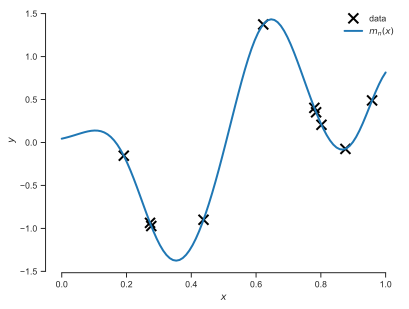

In [51]:
model.eval()
likelihood.eval()
# The test points on which we will make predictions
x_star = torch.linspace(0, 1, 100)[:, None]
# The predictive mean and variance for the test points
f_star = model(x_star)
m_star = f_star.mean
fig, ax = plt.subplots()
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(x_star, m_star.detach(), lw=2, label='$m_n(x)$')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

The variance on the same test points is:

/opt/homebrew/lib/python3.11/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


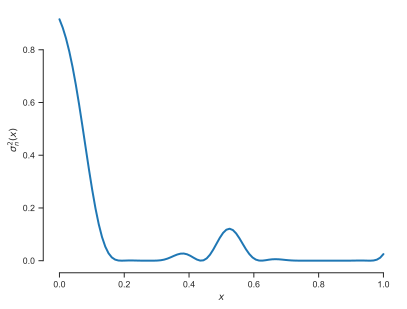

In [52]:
# Now the variance on the same test points
fig, ax = plt.subplots()
v_star = f_star.variance
ax.plot(x_star, v_star.detach(), lw=2, label='$\sigma_n^2(x)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$\sigma_n^2(x)$')
sns.despine(trim=True);

Notice that the variance is zero wherever we have an observation.

Having the posterior mean and variance, we can derive 95\% predictive intervals for $f(x^*)$ and $y^*$.
For $f(x^*)$ these are:

$$
m_n(\mathbf{x}^*)) - 2\sigma_n(\mathbf{x}^*) \le f(\mathbf{x}^*) \le m_n(\mathbf{x}^*)) + 2\sigma_n(\mathbf{x}^*).
$$

Let's plot this:

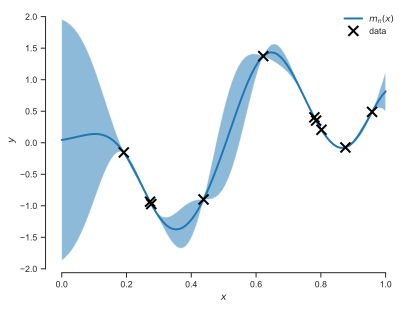

In [59]:
fig, ax = plt.subplots()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
f_lower = m_star - 2.0 * torch.sqrt(v_star)
f_upper = m_star + 2.0 * torch.sqrt(v_star)
ax.fill_between(
    x_star.detach().flatten(),
    f_lower.detach().flatten(),
    f_upper.detach().flatten(),
    alpha=0.5
)
ax.plot(x_star, m_star.detach(), lw=2, label='$m_n(x)$')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Let's also put the actual function there for comparison:

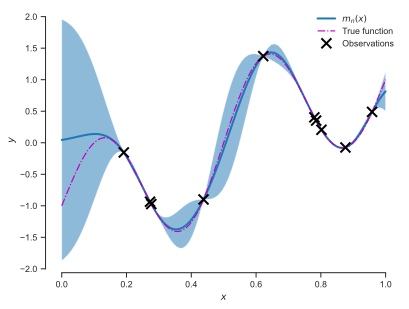

In [60]:
fig, ax = plt.subplots()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
f_lower = m_star - 2.0 * torch.sqrt(v_star)
f_upper = m_star + 2.0 * torch.sqrt(v_star)
ax.fill_between(
    x_star.detach().flatten(),
    f_lower.detach().flatten(),
    f_upper.detach().flatten(),
    alpha=0.5
)
ax.plot(x_star, m_star.detach(), lw=2, label='$m_n(x)$')
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.plot(
    X,
    Y,
    'kx',
    markersize=10,
    markeredgewidth=2,
    label='Observations'
)
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

You see that the actual function is almost entirely within the blue bounds.
It is ok that it is a bit off because these are 95% prediction intervals.
About 5% of the function can be off.

That's good.
However, we have much more information encoded in the posterior GP.
It is a probability measure over the space of functions.
How do we sample functions?
Well, you can't sample functions.
They are infinite objects.
But you can sample the *function values* on many test points.
The joint probability density of the function values at any collection of set points is a multivariate Gaussian.
We did it manually in the last lecture.
In this lecture, we will use the capabilities of ``GPyTorch``.
Here it is:

In [61]:
# Here is how you take the samples
f_post_samples = f_star.sample(sample_shape=torch.Size([10]))
# Here is the size of f_post_samples
print(f_post_samples.shape)

torch.Size([10, 100])


/opt/homebrew/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/linear_operator/operators/_linear_operator.py:2051: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.. Using symeig method.
  warnings.warn(


This is ``test points x number of outputs (1 here) x number of samples``.
Let's plot them along with the data and the truth:

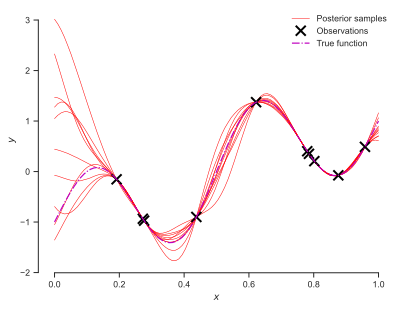

In [64]:
fig, ax = plt.subplots(dpi=100)
ax.plot(x_star, f_post_samples.detach().T, 'r', lw=0.5)
ax.plot([], [], 'r', lw=0.5, label="Posterior samples")
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='Observations')
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

Okay, the length scale we have assumed does not match the length scale of the actual function perfectly.
But that's how it is.
In real problems, you won't know this function anyway.

As always, it is a good idea to arrange your code in functions for reusability:

In [98]:
def plot_1d_regression(
    x_star,
    model,
    ax=None,
    f_true=None,
    num_samples=10
):
    """Plot the posterior predictive.
    
    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.
    
    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance

    f_lower = (
        m_star - 2.0 * torch.sqrt(v_star)
    )
    f_upper = (
        m_star + 2.0 * torch.sqrt(v_star)
    )
    
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(x_star, m_star.detach(), lw=2, label='$m_n(x)$')
   
    ax.fill_between(
        x_star.flatten().detach(),
        f_lower.flatten().detach(),
        f_upper.flatten().detach(),
        alpha=0.5,
        label='$f(\mathbf{x}^*)$ 95% pred.'
    )
    
    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )
        
    ax.plot(model.train_inputs[0].flatten().detach(),
            model.train_targets.detach(),
            'kx',
            markersize=10,
            markeredgewidth=2,
            label='Observations'
    )

    if num_samples > 0:
        f_post_samples = f_star.sample(
            sample_shape=torch.Size([10])
        )
        ax.plot(x_star, f_post_samples.T.detach(), 'r', lw=0.5)
        ax.plot([], [], 'r', lw=0.5, label="Posterior samples")
        
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    plt.legend(loc='best', frameon=False)
    sns.despine(trim=True);

Let's test it:

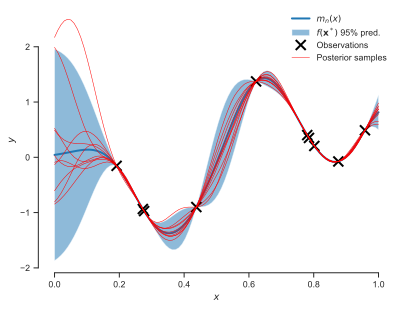

In [99]:
plot_1d_regression(x_star, model)

## Diagnostics: How do you know if the fit is good?

To objective test the resulting model, we need a *validation dataset* consisting of the inputs:

$$
\mathbf{x}^v_{1:n^v} = \left(\mathbf{x}^v_1,\dots,\mathbf{x}^v_{n^v}\right),
$$

and corresponding observed outputs:

$$
\mathbf{y}^v_{1:n^v} = \left(y^v_1,\dots,y^v_{n^v}\right).
$$

We will use this validation dataset to define some diagnostics.
Let's do it directly through the 1D example above.
First, we generate some validation data:

In [100]:
n_v = 100
X_v = np.random.rand(n_v)[:, None]
Y_v = f_true(X_v)

### Point-predictions

Point-predictions only use $m_n\left(\mathbf{x}^v_i\right)$.
Of course, when there is a lot of noise, they are not very useful.
But let's look at what we get anyway.
(In the questions section, I will ask you to reduce the noise and repeat).

The simplest thing we can do is to compare $y^v_i$ to $m_n\left(\mathbf{x}^v_i\right)$.
We start with the *mean square error*:

$$
\operatorname{MSE} := \frac{1}{n^v}\sum_{i=1}^{n^v}\left[y^v_i-m_n\left(\mathbf{x}^v_i\right)\right]^2.
$$

In [104]:
f_v = model(torch.from_numpy(X_v).float())
m_v = f_v.mean.detach().numpy()
v_v = f_v.variance.detach().numpy()
mse = np.mean((Y_v - m_v) ** 2)
print(f'MSE = {mse:1.2f}')

MSE = 1.25


/opt/homebrew/lib/python3.11/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


This could be more intuitive, though.
A somewhat intuitive measure is [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), also known as $R^2$, *R squared*.
It is defined as:

$$
R^2 = 1 - \frac{\sum_{i=1}^{n^v}\left[y_i^v - m_n(\mathbf{x}_i^v)\right]^2}{\sum_{i=1}^{n^v}\left[y_i^v-\bar{y}^v\right]^2},
$$

where $\bar{y}^v$ is the mean of the observed data:

$$
\bar{y}^v = \frac{1}{n^v}\sum_{i=1}^{n^v}y_i^v.
$$

The interpretation of $R^2$, and take this with a grain of salt, is that it gives the percentage of variance of the data explained by the model.
A score of $R^2=1$ is a perfect fit.
In our data, we get:

In [105]:
R2 = 1.0 - np.sum((Y_v - m_v) ** 2) / np.sum((Y_v - np.mean(Y_v)) ** 2)
print(f'R2 = {R2:1.2f}')

R2 = -188.47


Finally, on point-predictions, we can simply plot the predictions vs the observations:

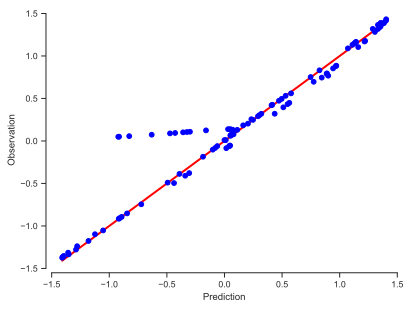

In [106]:
fig, ax = plt.subplots()
y_range = np.linspace(Y_v.min(), Y_v.max(), 50)
ax.plot(y_range, y_range, 'r', lw=2)
ax.plot(Y_v, m_v, 'bo')
ax.set_xlabel('Prediction')
ax.set_ylabel('Observation')
sns.despine(trim=True);

### Questions

+ Experiment with different length scales for the kernel.
What happens to the posterior mean and the 95% predictive error bar as the length scale increases (decreases)?

+ Experiment with different kernel variances. It specifies our prior variance about the function values. What is its effect?

+ Try some other kernels. 